In [385]:
# Install the transformers library from the Hugging Face repository
# !c:/Users/benjamin.guerrieri/AppData/Local/Programs/Python/Python311/python.exe -m pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org pip install -q git+https://github.com/huggingface/transformers.git 

In [386]:
# Install the 'timm' library using pip
# !c:/Users/benjamin.guerrieri/AppData/Local/Programs/Python/Python311/python.exe -m pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org pip install -q timm

The model we are loading is the "microsoft/table-transformer-detection" model. This model is designed to perform object detection tasks specifically on tabular data, such as tables in documents or spreadsheets.

We will visualize our image with matplotlib. The function creates a visualization by overlaying rectangles (bounding boxes) on the image to represent the detected objects and adding text annotations with the corresponding label and score.

In [387]:
import matplotlib.pyplot as plt
path = 'table.png'
from transformers import DetrFeatureExtractor
feature_extractor = DetrFeatureExtractor()
# Define colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_rows_and_cols(pil_img, scores, labels, boxes):
    # Create a figure for visualization
    plt.figure(figsize=(16, 10))

    # Display the PIL image
    plt.imshow(pil_img)

    # Get the current axis
    ax = plt.gca()

    # Repeat the COLORS list multiple times for visualization
    colors = COLORS * 100
    i = 1
    # Iterate through scores, labels, boxes, and colors for visualization
    for score, label, (xmin, ymin, xmax, ymax), c in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        # Add a rectangle to the image for the detected object's bounding box
        if model.config.id2label[label] == 'table row' or model.config.id2label[label] == 'table column':
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))

            # Prepare the text for the label and score
            text = f'{model.config.id2label[label]}: {str(i)}'

            # Add the label and score text to the image
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
        i+=1

    # Turn off the axis
    plt.axis('off')

    # Display the visualization
    plt.show()

def plot_spanning_cells(pil_img, scores, labels, boxes):
    # Create a figure for visualization
    plt.figure(figsize=(16, 10))

    # Display the PIL image
    plt.imshow(pil_img)

    # Get the current axis
    ax = plt.gca()

    # Repeat the COLORS list multiple times for visualization
    colors = COLORS * 100

    # Iterate through scores, labels, boxes, and colors for visualization
    for score, label, (xmin, ymin, xmax, ymax), c in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        if model.config.id2label[label] == 'table spanning cell':
            # Add a rectangle to the image for the detected object's bounding box
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))

            # Prepare the text for the label and score
            text = f'{model.config.id2label[label]}: {score:0.2f}'

            # Add the label and score text to the image
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))

    # Turn off the axis
    plt.axis('off')

    # Display the visualization
    plt.show()

  This has detected the presence of a table perfectly. We will now try to detect the rows and columns. As noted in the article, two separate approaches were used for this different objectives.

In [388]:
# Import the necessary libraries
from PIL import Image

# Download the image file from the specified Hugging Face repository and location
# Use either of the provided 'repo_id' lines depending on your use case
file_path = path

# Open the downloaded image using the PIL library and convert it to RGB format
image = Image.open(file_path).convert("RGB")

# Get the original width and height of the image
width, height = image.size

# Resize the image to 90% of its original dimensions
resized_image = image.resize((int(width * 0.9), int(height * 0.9)))

In [389]:
# Use the feature extractor to encode the resized image

encoding = feature_extractor(image, return_tensors="pt")

# Get the keys of the encoding dictionary
keys = encoding.keys()

Let's load the model from the hub, and perform a forward pass.

In [390]:
# Import the TableTransformerForObjectDetection class from the transformers library
from transformers import TableTransformerForObjectDetection

# Load the pre-trained Table Transformer model for table structure recognition
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")


In [391]:
import torch
with torch.no_grad():
  outputs = model(**encoding)

Let's visualize the results!

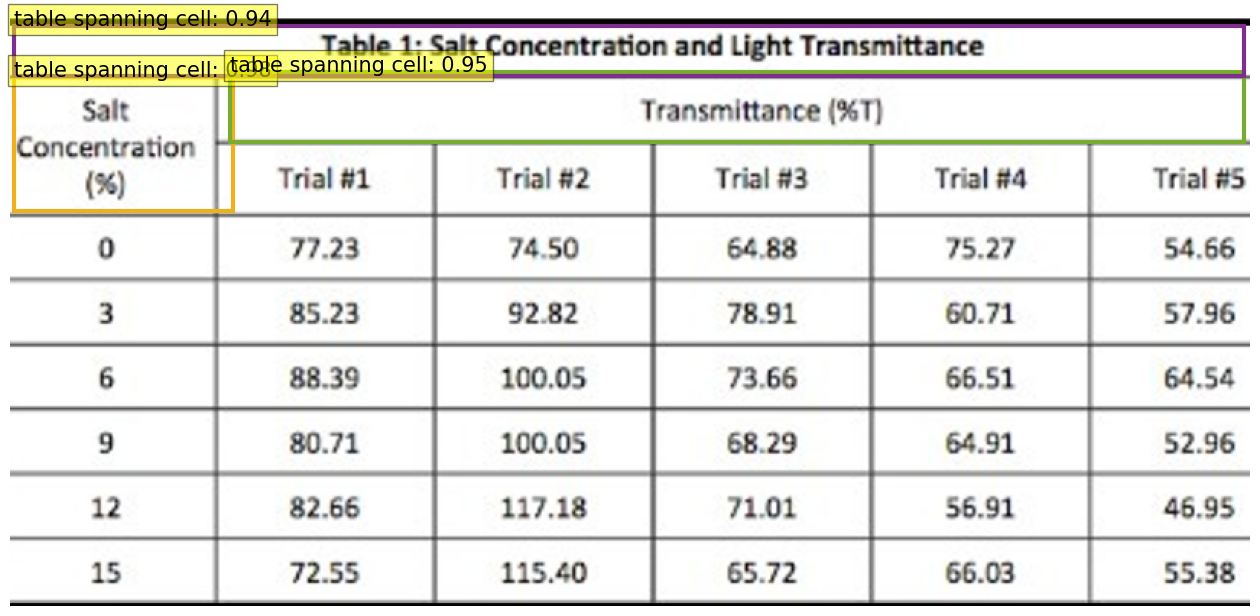

In [392]:
# Create a list of target sizes for post-processing
# 'image.size[::-1]' swaps the width and height to match the target size format (height, width)
target_sizes = [image.size[::-1]]

# Post-process the object detection outputs using the feature extractor
# Use a threshold of 0.6 for confidence
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]

# Plot the visualization of the results
plot_spanning_cells(image, results['scores'], results['labels'], results['boxes'])
#figure out how many rows and columns each spanning cell takes up


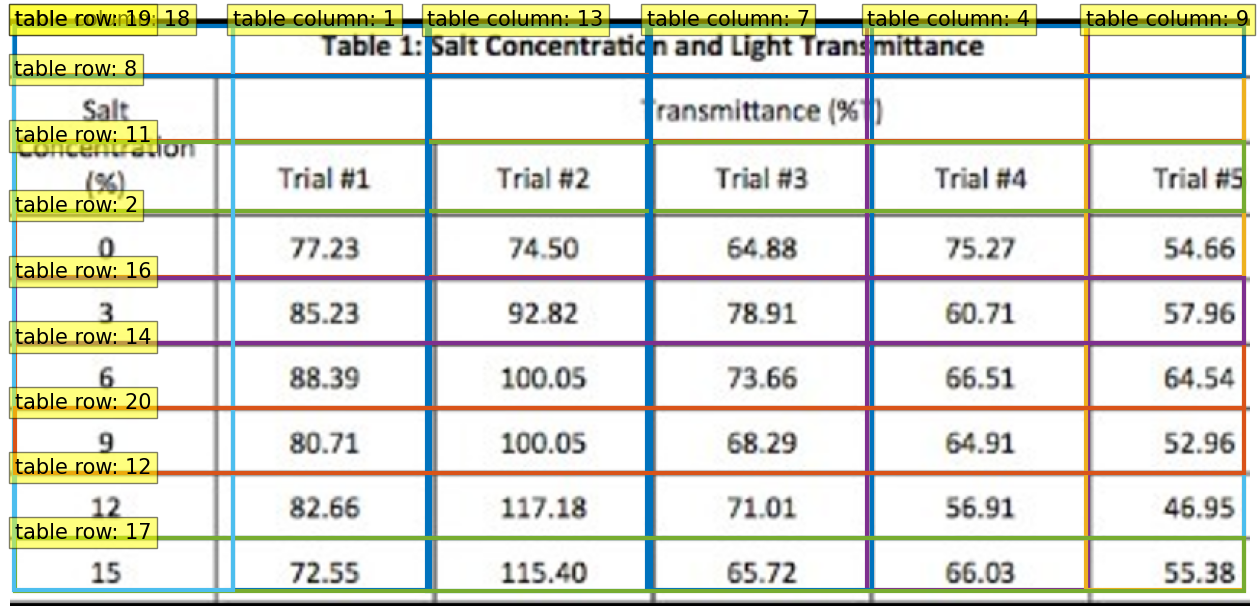

In [393]:
plot_rows_and_cols(image, results['scores'], results['labels'], results['boxes'])

In [394]:
model.config.id2label

{0: 'table',
 1: 'table column',
 2: 'table row',
 3: 'table column header',
 4: 'table projected row header',
 5: 'table spanning cell'}

In [395]:
import pandas as pd
from pytesseract import pytesseract
path_to_cmd = r"C:/Program Files/Tesseract-OCR/tesseract.exe"
pytesseract.tesseract_cmd = path_to_cmd


def isolate_cells(image, row_boxes, col_boxes, label_ids, id2label):
    row_boxes = sorted(row_boxes, key=lambda x: (x[1], x[0]))  # Sort by ymin and then xmin
    col_boxes = sorted(col_boxes, key=lambda x: (x[0], x[1]))  # Sort by xmin and then ymin
    
    cell_data = []
    
    for row_index, row_box in enumerate(row_boxes):
        for col_index, col_box in enumerate(col_boxes):
            # Extract coordinates for the current cell
            xmin_row, ymin_row, xmax_row, ymax_row = map(int, row_box)
            xmin_col, ymin_col, xmax_col, ymax_col = map(int, col_box)
            
            # Crop the current cell from the image
            cell_image = image.crop((xmin_col, ymin_row, xmax_col, ymax_row))
            bbox = (xmin_col, ymin_row, xmax_col, ymax_row)
            # Add cell data to the list
            cell_data.append((cell_image, row_index, col_index, bbox))
    
    # Sort the cell data based on row and column indices
    cell_data.sort(key=lambda x: (x[1], x[2]))
    
    return cell_data

# Example usage:
row_label_id = model.config.label2id['table row']
col_label_id = model.config.label2id['table column']

row_boxes = results['boxes'][results['labels'] == row_label_id]
col_boxes = results['boxes'][results['labels'] == col_label_id]

isolated_cells_data = isolate_cells(image, row_boxes, col_boxes, [row_label_id, col_label_id], model.config.id2label)

# # Create a DataFrame from the isolated cell data
# columns = ['Row', 'Column', 'Cell Contents']
# df_cells = pd.DataFrame(columns=columns)

# rows_list = []

# # Save or display the isolated cell images and update the list
# for i, (cell_image, row_index, col_index, bbox) in enumerate(isolated_cells_data):
#     # image_path = f'isolated_cell_{i}.png'
#     # cell_image.save(image_path)
#     result = pytesseract.image_to_string(cell_image)
#     cleaned_result = result.replace('\n', ' ').strip()

#     rows_list.append({'Row': row_index, 'Column': col_index, 'Cell Contents': cleaned_result})

# # Create a DataFrame from the list
# df_cells = pd.DataFrame(rows_list)

# # Sort the DataFrame based on Row and Column columns
# df_cells = df_cells.sort_values(by=['Row', 'Column']).reset_index(drop=True)

# # Display the sorted DataFrame
# df_cells


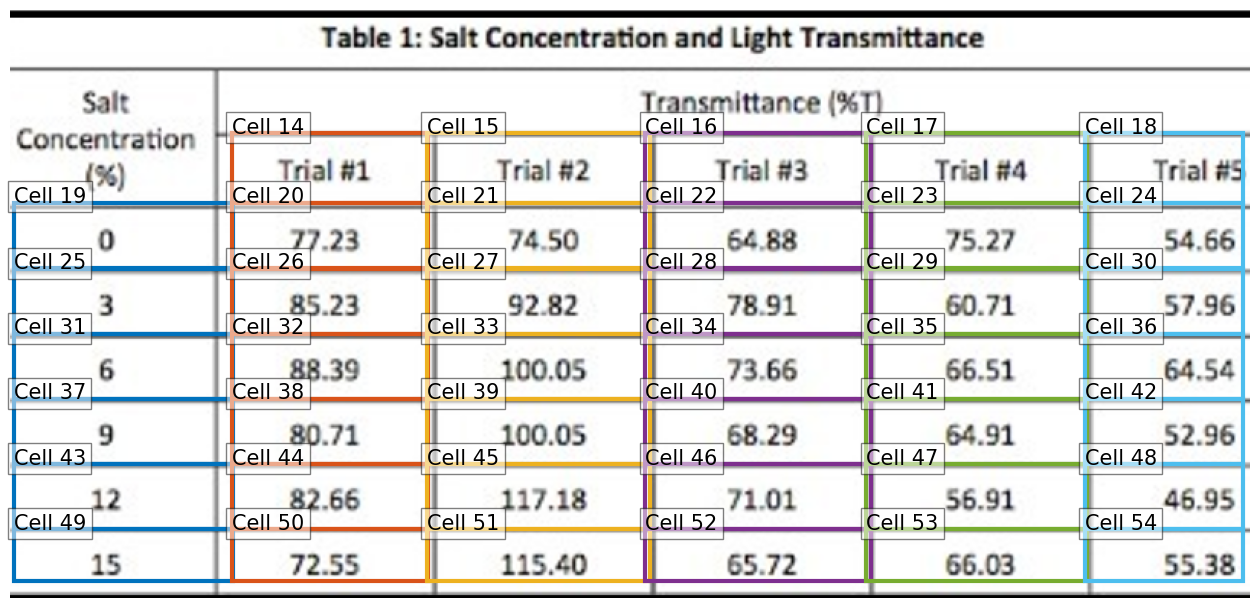

{tensor(4.8517): [tensor([  2.2850,   4.8517, 853.4520,  39.5474])], tensor(36.6679): [tensor([  2.2850,  36.6679, 153.7580, 133.0568])], tensor(36.6679): [tensor([151.5377,  36.6679, 853.4953,  85.4321])], 85: [(153, 85, 289, 133), (288, 85, 442, 133), (439, 85, 595, 133), (592, 85, 745, 133), (743, 85, 853, 133)], 133: [(2, 133, 154, 178), (153, 133, 289, 178), (288, 133, 442, 178), (439, 133, 595, 178), (592, 133, 745, 178), (743, 133, 853, 178)], 179: [(2, 179, 154, 224), (153, 179, 289, 224), (288, 179, 442, 224), (439, 179, 595, 224), (592, 179, 745, 224), (743, 179, 853, 224)], 224: [(2, 224, 154, 269), (153, 224, 289, 269), (288, 224, 442, 269), (439, 224, 595, 269), (592, 224, 745, 269), (743, 224, 853, 269)], 269: [(2, 269, 154, 314), (153, 269, 289, 314), (288, 269, 442, 314), (439, 269, 595, 314), (592, 269, 745, 314), (743, 269, 853, 314)], 314: [(2, 314, 154, 359), (153, 314, 289, 359), (288, 314, 442, 359), (439, 314, 595, 359), (592, 314, 745, 359), (743, 314, 853, 359)

[(6, 'h'), (2, 'v'), (5, 'h')]

In [396]:

# def is_bbox_intersecting(bbox1, bbox2):
#     x_min1, y_min1, x_max1, y_max1 = bbox1
#     x_min2, y_min2, x_max2, y_max2 = bbox2

#     return not (x_max1 < x_min2 or x_min1 > x_max2 or y_max1 < y_min2 or y_min1 > y_max2)



def is_bbox_majority_within(bbox1, bbox2, threshold=0.5):
    x_min1, y_min1, x_max1, y_max1 = bbox1
    x_min2, y_min2, x_max2, y_max2 = bbox2

    intersection_x_min = max(x_min1, x_min2)
    intersection_y_min = max(y_min1, y_min2)
    intersection_x_max = min(x_max1, x_max2)
    intersection_y_max = min(y_max1, y_max2)

    intersection_area = max(0, intersection_x_max - intersection_x_min) * max(0, intersection_y_max - intersection_y_min)
    cell_area = (x_max1 - x_min1) * (y_max1 - y_min1)

    return (intersection_area / cell_area) > threshold

def is_cell_outside_all_bounding_boxes(cell_bbox, spanning_boxes):
    for spanning_box in spanning_boxes:
        if is_bbox_majority_within(cell_bbox, spanning_box):
            return False
    return True

def plot_cells(pil_img, cell_data, spanning_cells):
    # Create a figure for visualization
    plt.figure(figsize=(16, 10))

    # Display the PIL image
    plt.imshow(pil_img)

    # Get the current axis
    ax = plt.gca()

    # Repeat the COLORS list multiple times for visualization
    colors = COLORS * 100
    all_cells = []
    # Iterate through scores, labels, boxes, and colors for visualization
    for i, (cell_image, row_index, col_index, bbox) in enumerate(cell_data):
        xmin_col, ymin_row, xmax_col, ymax_row = bbox
        if is_cell_outside_all_bounding_boxes(bbox,spanning_cells):
            ax.add_patch(plt.Rectangle((xmin_col, ymin_row), xmax_col-xmin_col, ymax_row-ymin_row,
                                        fill=False, color=colors[i], linewidth=3))
            text = f'Cell {i + 1}'
            ax.text(xmin_col, ymin_row, text, fontsize=15,
                            bbox=dict(facecolor='white', alpha=0.5))
            all_cells.append(bbox)
        else:
            i-=1
    for spanning_bbox in spanning_cells:
        all_cells.append(spanning_bbox)
    all_cells = sorted(all_cells, key=lambda x: x[0]) #gets in l to r top down order hopefully
    all_cells = sorted(all_cells, key=lambda x: x[1]) #gets in l to r top down order hopefully
    
    # Turn off the axis
    plt.axis('off')

    # Display the visualization
    plt.show()
    return all_cells

span_label_id = model.config.label2id['table spanning cell']
spanning_boxes = results['boxes'][results['labels'] == span_label_id]
#fix small error
spanning_boxes = sorted(spanning_boxes, key=lambda x: (x[0],x[1])) #gets in correct order
for i, _ in enumerate(spanning_boxes):
    for j,_ in enumerate(spanning_boxes):
        if abs(spanning_boxes[i][1] - spanning_boxes[j][1]) <= 5:
            spanning_boxes[i][1] = spanning_boxes[j][1]
        if abs(spanning_boxes[i][0] - spanning_boxes[j][0]) <= 5:
            spanning_boxes[i][0] = spanning_boxes[j][0]



sorted_cells = plot_cells(image,isolated_cells_data,spanning_boxes)
# sorted_cells

def find_longest_row_or_column(subset):
    # Assuming each cell in the subset has the format (x_min, y_min, x_max, y_max)
    subset.sort(key=lambda cell: cell[0])  # Sort cells based on x_min

    longest_row = max(subset, key=lambda cell: cell[2] - cell[0])

    subset.sort(key=lambda cell: cell[1])  # Sort cells based on y_min

    longest_column = max(subset, key=lambda cell: cell[3] - cell[1])

    return longest_row, longest_column

def subset_cells_count(spanning_box, cell_boxes):
    # Assuming bounding box format is (x_min, y_min, x_max, y_max)
    span_x_min, span_y_min, span_x_max, span_y_max = spanning_box

    # Check if spanning box spans multiple columns or rows
    # is_horizontal_span = (span_x_max - span_x_min) > (span_y_max - span_y_min)

    # if is_horizontal_span:
        # Spanning multiple columns
    subset = [cell for cell in cell_boxes if span_x_min+-5 <= cell[0] <= span_x_max]
    rows = {}
    for cell in subset:
        row_index = (cell[1])  # Assuming cells are aligned to integer row positions
        if row_index not in rows:
            rows[row_index] = []
        rows[row_index].append(cell)

    # Find the maximum count within each row
    # num_rows = len(rows)
    max_cells_per_row = max(len(cells) for cells in rows.values())

    # return max_cells_per_row, 'h'
# else:
    # Spanning multiple rows
    subset = [cell for cell in cell_boxes if span_y_min+-5 <= cell[1] <= span_y_max]
    columns = {}
    for cell in subset:
        col_index = (cell[0])  # Assuming cells are aligned to integer column positions
        if col_index not in columns:
            columns[col_index] = []
        columns[col_index].append(cell)
    # num_cols = len(columns)

    # Find the maximum count within each column
    max_cells_per_column = max(len(cells) for cells in columns.values())
    print(rows,columns)
    if max_cells_per_column >= max_cells_per_row:
        return (max_cells_per_column, 'v')
    else:
        return (max_cells_per_row, 'h')
        # return max_cells_per_column, 'v'

spanning_data = []
for box in spanning_boxes:
    spanning_data.append(subset_cells_count(box, sorted_cells))
spanning_data


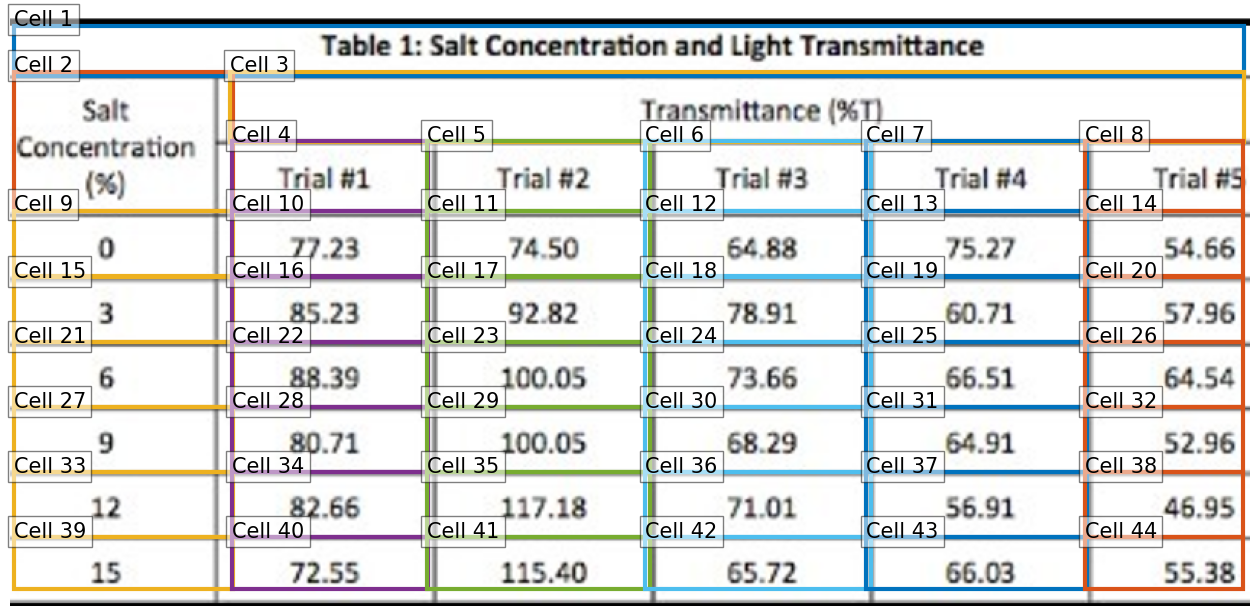

In [397]:
plt.figure(figsize=(16, 10))

# Display the PIL image
plt.imshow(image)
colors = COLORS * 100

# Get the current axis
ax = plt.gca()

for i, bbox in enumerate(sorted_cells):
    xmin_col, ymin_row, xmax_col, ymax_row = bbox
    ax.add_patch(plt.Rectangle((xmin_col, ymin_row), xmax_col-xmin_col, ymax_row-ymin_row,
                                fill=False, color=colors[i], linewidth=3))
    text = f'Cell {i + 1}'
    ax.text(xmin_col, ymin_row, text, fontsize=15,
                    bbox=dict(facecolor='white', alpha=0.5))


# Turn off the axis
plt.axis('off')

# Display the visualization
plt.show()

In [398]:
# max_row, max_col = -1, -1
# for i in range(len(df_cells)):
#     max_row = max(max_row, int(df_cells.loc[i, 'Row']))
#     max_col = max(max_col, int(df_cells.loc[i, 'Column']))
# max_row+=1
# max_col+=1
# final_array = [[0] * max_col for _ in range(max_row)]
 
# for i in range(len(df_cells)):
#     final_array[int(df_cells.loc[i, 'Row'])][int(df_cells.loc[i, 'Column'])] = df_cells.loc[i, 'Cell Contents']
 
# new_df = pd.DataFrame(final_array)
# new_df

In [399]:
# finalized_data = new_df

# with pd.ExcelWriter(r'C:/Users/benjamin.guerrieri/Documents/TableOCR/PipeLine/test.xlsx') as writer:
#     finalized_data.to_excel(writer,sheet_name = 'table',index = False)

In [400]:
spanning_indexes = [i for i, data in enumerate(sorted_cells) if isinstance(data, torch.Tensor)]
sorted_cells = [tuple(data.tolist()) if isinstance(data, torch.Tensor) else tuple(data) for data in sorted_cells]

def create_2d_array_with_ocr(sorted_cells, image, row_threshold=5):
    rows = []
    current_row = []

    for cell_bbox in sorted_cells:
        if not current_row or abs(current_row[-1][1] - cell_bbox[1]) <= row_threshold:
            # Add cell to the current row
            current_row.append(cell_bbox)
        else:
            # Start a new row
            rows.append(current_row)
            current_row = [cell_bbox]

    # Add the last row
    rows.append(current_row)

    # Create the final 2D array with bounding box coordinates and OCR results
    final_array = []

    for row in rows:
        row_result = []
        for cell_bbox in row:
            xmin, ymin, xmax, ymax = cell_bbox
            cell_image = image.crop((xmin, ymin, xmax, ymax))
            ocr_result = pytesseract.image_to_string(cell_image)
            ocr_result = ocr_result.replace('\n', ' ').strip()
            row_result.append(ocr_result)
        final_array.append(row_result)

    return final_array

# Assuming 'image' is your original image
final_array = create_2d_array_with_ocr(sorted_cells, image)
col_len = 0
row_len = len(final_array)
# Display the 2D array
for c in final_array:
    col_len = max(col_len, len(c))
    print(c)
print(row_len,col_len)
spanning_indexes
spanning_data


['Table 1: Salt Concentration and Light Transmittance']
['Salt Concentration {%)', 'Transmittance (%T)']
['Trial #1', '', '', '', '']
['', '77.23', '| 74.50', '', '', '']
['', '', '', '78.91', '60.71', '']
['', '88.39', '| 100.05', '73.66', '', '']
['', '80.71', '| 100.05', '68.29', '', '']
['', '82.66', '| 117.18', '| 71.01', '56.91', '']
['', '72.55', '| 115.40', '| 65.72', '', '55.38']
9 6


[(6, 'h'), (2, 'v'), (5, 'h')]

In [401]:
from openpyxl import Workbook
from openpyxl.styles import Alignment

# Assuming 'final_array', 'row_len', 'col_len', 'spanning_indexes', 'spanning_data' are defined

# Create a new workbook
workbook = Workbook()
sheet = workbook.active
i = 0
# Iterate through the rows in 'final_array'
for row_index, row_data in enumerate(final_array, start=1):
    # Iterate through the columns in each row
    for col_index, cell_data in enumerate(row_data, start=1):
        # Write data to the sheet
        sheet.cell(row=row_index, column=col_index, value=cell_data)
       
# Iterate through the spanning cells and merge accordingly
for row_index, row_data in enumerate(final_array, start=1):
    # Iterate through the columns in each row
    for col_index, cell_data in enumerate(row_data, start=1):
        if i < len(spanning_data) and spanning_data[i] is not None:
            spanning_index, direction = spanning_data[i]
            print(row_index,col_index,i)
            if direction == 'h':
                sheet.merge_cells(start_row=row_index, end_row=row_index, start_column=col_index, end_column=col_index + spanning_index - 1)
            elif direction == 'v':
                sheet.merge_cells(start_row=row_index, end_row=row_index + spanning_index - 1, start_column=col_index, end_column=col_index)
        i+=1
    
       
# Apply alignment to center text in merged cells
for row in sheet.iter_rows(min_row=1, max_row=row_len, min_col=1, max_col=col_len):
    for cell in row:
        cell.alignment = Alignment(horizontal='center', vertical='center')

# Save the workbook
workbook.save('output.xlsx')


1 1 0
2 1 1
2 2 2
